In [1]:
from cycler import cycler
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sphincter.data_preparation import load_prepared_data

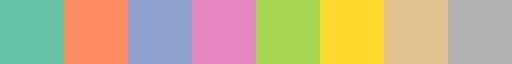

In [2]:
PLOTS_DIR = Path("") / ".." / "plots"
CMAP = plt.get_cmap('Set2')
display(CMAP)
plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)
age_to_color = {"adult": CMAP.colors[0], "old": CMAP.colors[1]}

In [3]:
raw = pd.read_excel("../data/raw/angio-architecture/CapillarySummary_Allcount3.xlsx")
raw.head()

,MouseID,LocID,Condition,Volume,CapOrder,CapVesLL,CapVesNum,CapVesVol,CapVesDiam,CapVesTortous,CapMeanVesLength
0,40520,Loc1,Adult,4.497587e+08,pa,0.000018,1.667561e-07,0.006146,19.656555,1.075209,109.953663
1,40520,Loc1,Adult,4.497587e+08,1stCap,0.000009,1.578624e-07,0.001323,13.960650,1.172599,59.555222
2,40520,Loc1,Adult,4.497587e+08,2ndCap,0.000017,2.912673e-07,0.001923,12.534968,1.153572,56.678658
3,40520,Loc1,Adult,4.497587e+08,3rdCap,0.000031,5.358429e-07,0.002987,11.757314,1.180417,57.003299
4,40520,Loc1,Adult,4.497587e+08,4thCap,0.000048,9.160468e-07,0.004396,11.374330,1.141417,51.982389


# Look at raw data

This cell plots the raw data to check that it agrees with the graph in the previous analysis: it does!

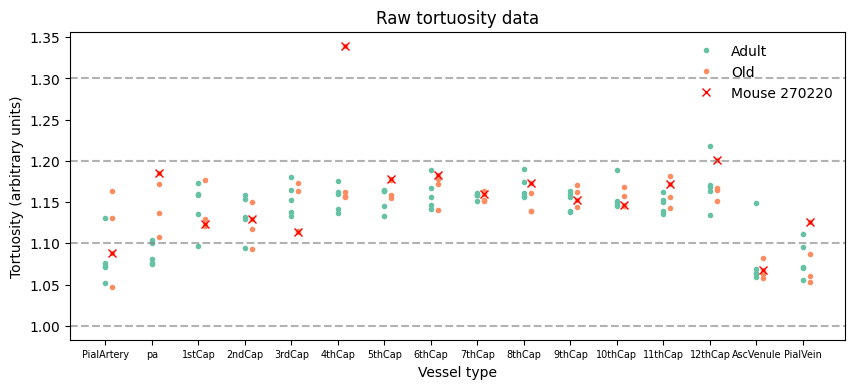

In [4]:
CAP_ORDER = [
    'PialArtery',
    'pa', 
    '1stCap', 
    '2ndCap', 
    '3rdCap',
    '4thCap',
    '5thCap',
    '6thCap',
    '7thCap',
    '8thCap',
    '9thCap',
    '10thCap',
    '11thCap',
    '12thCap',
    'AscVenule',
    'PialVein',
]
x = np.linspace(0, 1, len(CAP_ORDER))

f, ax = plt.subplots(figsize=[10, 4])

cap_to_x = dict(zip(CAP_ORDER, x))

legend_handles = {}

for age, agedf in raw.groupby("Condition"):
    age_offset = 0.0 if age == "Adult" else 0.01
    color = age_to_color[age.lower()]
    for cap, agecapdf in agedf.groupby("CapOrder"):
        legend_handles[age] = ax.plot(
            [cap_to_x[cap] + age_offset] * len(agecapdf),
            agecapdf["CapVesTortous"],
            color=color,
            marker=".",
            linewidth=0,
        )[0]
        if 270220 in agecapdf["MouseID"].values:
            agecapdf_mouse = agecapdf.loc[lambda df: df["MouseID"] == 270220]
            legend_handles["Mouse 270220"] = ax.plot(
                [cap_to_x[cap] + age_offset] * len(agecapdf_mouse),
                agecapdf_mouse["CapVesTortous"],
                color="red",
                marker="x",
                linewidth=0,
            )[0]
for y in [1.0, 1.1, 1.2, 1.3]:
    ax.axhline(y, linestyle="--", color="gray", alpha=0.6)
ax.legend(legend_handles.values(), legend_handles.keys(), frameon=False)
ax.set_xticks(x, CAP_ORDER, fontsize="x-small");
ax.set(title="Raw tortuosity data", xlabel="Vessel type", ylabel="Tortuosity (arbitrary units)");

There is a big outlier in the "4thCap" category: probably this measurement should be ignored.

In [5]:
raw.sort_values("CapVesTortous", ascending=False).head()

,MouseID,LocID,Condition,Volume,CapOrder,CapVesLL,CapVesNum,CapVesVol,CapVesDiam,CapVesTortous,CapMeanVesLength
116,270220,Loc1,Old,4.785186e+08,4thCap,0.000048,7.502321e-07,0.003307,9.687573,1.339728,64.348908
79,180520,Loc1,Adult,4.393950e+08,12thCap,0.000007,1.411031e-07,0.001289,16.127971,1.217514,47.599449
127,270220,Loc1,Old,4.785186e+08,12thCap,0.000011,2.047987e-07,0.001183,10.443934,1.201615,55.394807
75,180520,Loc1,Adult,4.393950e+08,8thCap,0.000075,1.335928e-06,0.010110,13.194375,1.189882,55.980688
77,180520,Loc1,Adult,4.393950e+08,10thCap,0.000024,4.301369e-07,0.003817,13.871179,1.188914,56.021827


# Get prepared data

In [6]:
data = load_prepared_data("../data/prepared/tortuosity.json")
data.measurements.index = map(str, data.measurements.index)

In [7]:
data.measurements

,mouse,age,vessel_type,tortuosity
0,40520,adult,pa,1.075209
1,40520,adult,cap1,1.172599
2,40520,adult,cap2,1.153572
3,40520,adult,cap3,1.180417
4,40520,adult,cap4,1.141417
...,...,...,...,...
139,280420,adult,cap8,1.156224
140,280420,adult,cap9,1.137503
141,280420,adult,cap10,1.150419
142,280420,adult,cap11,1.149617


# Get model results

In [8]:
idata = az.InferenceData.from_zarr("../inferences/tortuosity/idata")
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

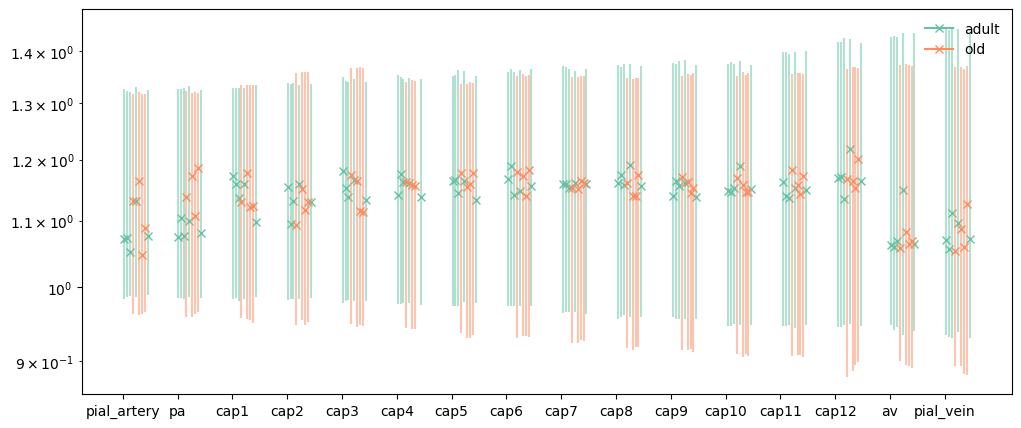

In [9]:
yrep_prior = idata.prior_predictive["yrep"].quantile([0.01, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile")
yrep_prior.columns = ["yrep_low", "yrep_high"]

g = (
    data.measurements
    .join(yrep_prior)
    .assign(x=lambda df: df["vessel_type"].cat.codes)
    .groupby(["age", "vessel_type"], observed=True)
)
scts = {}

f, ax = plt.subplots(figsize=[12, 5])

for (age, _), df in g:
    for i, row in df.iterrows():
        x = row["x"] + float(i) / 300
        mrk = ax.plot(x, row["tortuosity"], marker="x", color=age_to_color[age]);
        ax.vlines(x, row["yrep_low"], row["yrep_high"], color=age_to_color[age], alpha=0.5);
        scts[age] = mrk[0]
ax.set_xticks(range(len(data.measurements["vessel_type"].cat.categories)), data.measurements["vessel_type"].cat.categories);
ax.legend(scts.values(), scts.keys(), frameon=False);
ax.semilogy();

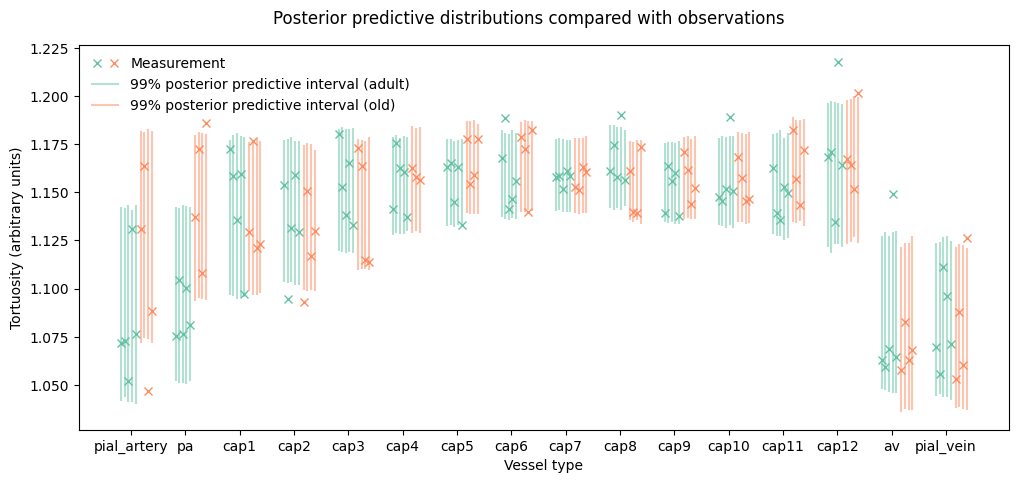

In [10]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

yrep_q = idata.posterior_predictive["yrep"].quantile([0.01, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile")
yrep_q.columns = ["yrep_low", "yrep_high"]

g = (
    data.measurements
    .join(yrep_q)
    .assign(x=lambda df: df["vessel_type"].cat.codes)
    .groupby(["age", "vessel_type"], observed=True)
)

f, ax = plt.subplots(figsize=[12, 5])

handles = {"Measurement": {}}
for (age, _), df in g:
    for i, row in df.reset_index().iterrows():
        x = row["x"] + float(i) / 15
        if age == "old":
            x += 0.18
        else:
            x -= 0.18
        mrk = ax.plot(x, row["tortuosity"], marker="x", linestyle="None", color=age_to_color[age]);
        vl = ax.vlines(x, row["yrep_low"], row["yrep_high"], color=age_to_color[age], alpha=0.5);
        handles["Measurement"][age] = mrk[0]
        handles[f"99% posterior predictive interval ({age})"] = vl
handles["Measurement"] = (handles["Measurement"]["adult"], handles["Measurement"]["old"])
ax.set_xticks(range(len(data.measurements["vessel_type"].cat.categories)), data.measurements["vessel_type"].cat.categories);
ax.legend(handles.values(), handles.keys(), frameon=False, handler_map={tuple: HandlerTuple(ndivide=None)});
ax.set(xlabel="Vessel type", ylabel="Tortuosity (arbitrary units)");
f.suptitle("Posterior predictive distributions compared with observations", y=0.95)
f.savefig(PLOTS_DIR / "tortuosity-ppc.png", bbox_inches="tight")

In [11]:
az.summary(idata, var_names=["nu", "lambda", "log_sigma_std"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,2.348,2.548,1.001,4.581,0.067,0.048,1172.0,1530.0,1.01
lambda[0],0.120,0.064,0.017,0.235,0.002,0.001,784.0,1275.0,1.01
lambda[1],0.104,0.057,0.016,0.206,0.002,0.001,979.0,1089.0,1.01
log_sigma_std[0],-0.770,0.184,-1.102,-0.405,0.003,0.002,3381.0,2606.0,1.00
log_sigma_std[1],-0.941,0.179,-1.261,-0.590,0.003,0.002,3633.0,2811.0,1.00
log_sigma_std[2],-1.018,0.169,-1.323,-0.689,0.003,0.002,3645.0,2621.0,1.00
log_sigma_std[3],-1.105,0.169,-1.408,-0.784,0.003,0.002,3235.0,2570.0,1.00
log_sigma_std[4],-1.242,0.164,-1.551,-0.938,0.003,0.002,4003.0,3033.0,1.00
log_sigma_std[5],-1.524,0.200,-1.901,-1.140,0.003,0.002,3335.0,2937.0,1.00
log_sigma_std[6],-1.613,0.180,-1.941,-1.271,0.003,0.002,3345.0,3068.0,1.00


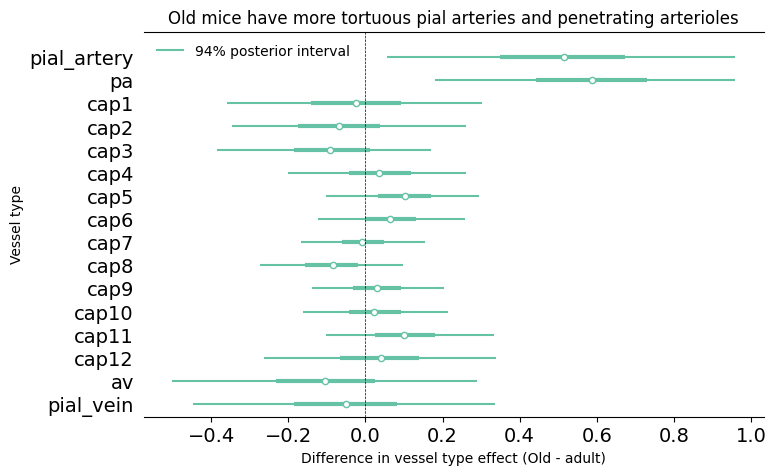

In [12]:
age_effects = (idata.posterior["a_age_vessel_type"]).rename("age_diff")
age_diff = age_effects.sel(age="old") - age_effects.sel(age="adult")

f, ax = plt.subplots(figsize=[8, 5])

az.plot_forest(age_diff, combined=True, ax=ax)
l = ax.collections[0]
ax.legend([l], ["94% posterior interval"], frameon=False)
ax.axvline(0, color="black", linestyle="--", linewidth=0.5)
yticks = ax.get_yticks()
ax.set_yticks(yticks, list(data.measurements["vessel_type"].cat.categories)[::-1]);
ax.set(
    xlabel="Difference in vessel type effect (Old - adult)",
    ylabel="Vessel type", 
    title="Old mice have more tortuous pial arteries and penetrating arterioles"
);
f.savefig(PLOTS_DIR / "tortuosity-effects.png", bbox_inches="tight")